In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../Data/income.csv")

In [3]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [4]:
df = df.drop(['education-num', 'label'], axis=1)

In [5]:
df.head()

,age,sex,education,marital-status,workclass,occupation,hours-per-week,income
0,27,Male,HS-grad,Never-married,Private,Craft-repair,40,<=50K
1,47,Male,Masters,Married,Local-gov,Exec-managerial,50,>50K
2,59,Male,HS-grad,Divorced,Self-emp,Prof-specialty,20,<=50K
3,38,Female,Prof-school,Never-married,Federal-gov,Prof-specialty,57,>50K
4,64,Female,11th,Widowed,Private,Farming-fishing,40,<=50K


In [6]:
con_cols = ['age','hours-per-week']
cat_cols = ['sex','education','marital-status','workclass','occupation']
lab_col = ['income']

In [7]:
print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(con_cols)} columns')
print(f'y_col     has {len(lab_col)} column')

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


Convert to categorical

In [8]:
for field in cat_cols:
    df[field] = df[field].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
age               30000 non-null int64
sex               30000 non-null category
education         30000 non-null category
marital-status    30000 non-null category
workclass         30000 non-null category
occupation        30000 non-null category
hours-per-week    30000 non-null int64
income            30000 non-null object
dtypes: category(5), int64(2), object(1)
memory usage: 851.3+ KB


In [10]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=101)

In [11]:
df.head()

,age,sex,education,marital-status,workclass,occupation,hours-per-week,income
6015,23,Female,HS-grad,Never-married,Private,Other-service,50,<=50K
28660,37,Female,Prof-school,Married,State-gov,Prof-specialty,39,>50K
12498,34,Male,Some-college,Divorced,Private,Adm-clerical,40,<=50K
22957,31,Male,HS-grad,Married,Private,Craft-repair,40,>50K
14848,20,Female,Some-college,Never-married,Private,Sales,25,<=50K


In [12]:
df.reset_index(drop=True, inplace=True)

In [13]:
df.head()

,age,sex,education,marital-status,workclass,occupation,hours-per-week,income
0,23,Female,HS-grad,Never-married,Private,Other-service,50,<=50K
1,37,Female,Prof-school,Married,State-gov,Prof-specialty,39,>50K
2,34,Male,Some-college,Divorced,Private,Adm-clerical,40,<=50K
3,31,Male,HS-grad,Married,Private,Craft-repair,40,>50K
4,20,Female,Some-college,Never-married,Private,Sales,25,<=50K


In [14]:
cats = np.stack([df[cat].cat.codes.values for cat in cat_cols], axis=1)
cons = np.stack([df[con].values for con in con_cols], axis=1)

Embedding Size

In [15]:
cat_sizes = [len(df[cat].cat.categories) for cat in cat_cols]

In [16]:
emb_cat_sizes = [(size, (size+1)//2) for size in cat_sizes]

In [17]:
emb_cat_sizes

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [18]:
cats[:5]

array([[ 0, 10,  3,  2,  6],
       [ 0, 12,  1,  4,  7],
       [ 1, 13,  0,  2,  0],
       [ 1, 10,  1,  2,  1],
       [ 0, 13,  3,  2,  9]], dtype=int8)

Convert cats and cons to tensor

In [19]:
cats = torch.tensor(cats, dtype=torch.int64)

In [20]:
cons = torch.tensor(cons, dtype=torch.float)

In [21]:
y = torch.tensor(df['income'].astype('category').cat.codes, dtype=torch.long)

In [22]:
batch_size = len(df)
test_size = int(batch_size * 0.25)

In [23]:
cats_train = cats[:batch_size - test_size]
cats_test = cats[batch_size - test_size : batch_size]
cons_train = cons[:batch_size - test_size]
cons_test = cons[batch_size - test_size : batch_size]
y_train = y[:batch_size - test_size]
y_test = y[batch_size - test_size : batch_size]

Define Model Class

In [33]:
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, no_cons, out_size, layers, p=0.5):
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(size, dimension) for size, dimension in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.b_normal = nn.BatchNorm1d(no_cons)
        
        no_cats = sum([size for _,size in emb_sizes])
        no_in = no_cats + no_cons
        
        layer_list = []
        
        for layer in layers:
            layer_list.append(nn.Linear(no_in, layer))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(layer))
            layer_list.append(nn.Dropout(p, inplace=True))
            no_in = layer
        layer_list.append(nn.Linear(no_in, out_size))
        
        self.layers = nn.Sequential(*layer_list)
        
    def forward(self, x_cons, x_cats):
        embeddings = []
        for i, emb in enumerate(self.embeds):
            embeddings.append(emb(x_cats[:,i]))
        
        x_cats = torch.cat(embeddings, axis=1)
        x_cats = self.emb_drop(x_cats)
        
        x_cons = self.b_normal(x_cons)
        x = torch.cat([x_cats, x_cons], axis=1)
        
        x = self.layers(x)
        return x

In [44]:
net = TabularModel(emb_cat_sizes, cons_test.shape[1], 2, [100,50], p=0.4)

In [45]:
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [47]:
import time
start_time = time.time()

epochs = 500
losses = []

for i in range(epochs):
    i+=1
    if CUDA:
        cats_train = cats_train.cuda()
        cons_train = cons_train.cuda()
        y_train = y_train.cuda()
    y_pred = net(cons_train, cats_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.76181191
epoch:  26  loss: 0.52185190
epoch:  51  loss: 0.47625852
epoch:  76  loss: 0.44442379
epoch: 101  loss: 0.41803634
epoch: 126  loss: 0.38890946
epoch: 151  loss: 0.36585873
epoch: 176  loss: 0.35086703
epoch: 201  loss: 0.33927247
epoch: 226  loss: 0.32596999
epoch: 251  loss: 0.31853104
epoch: 276  loss: 0.31321177
epoch: 301  loss: 0.30750823
epoch: 326  loss: 0.30185598
epoch: 351  loss: 0.30018619
epoch: 376  loss: 0.29914850
epoch: 401  loss: 0.29304457
epoch: 426  loss: 0.29133928
epoch: 451  loss: 0.28879648
epoch: 476  loss: 0.28672448
epoch: 500  loss: 0.28654024

Duration: 16 seconds


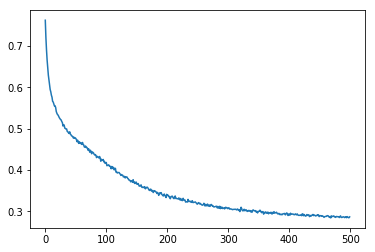

In [48]:
plt.plot(range(epochs), losses)

In [49]:
with torch.no_grad():
    if CUDA:
        cons_test = cons_test.cuda()
        cats_test = cats_test.cuda()
        y_test = y_test.cuda()
    y_pred = net.forward(cons_test, cats_test)
    loss = criterion(y_pred, y_test)

In [50]:
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.29763138


In [78]:
((y_pred.argmax(axis=1) == y_test)+0).sum().float()/f

tensor(6482., device='cuda:0')

In [77]:
y_test.shape

torch.Size([7500])